In [2]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
from sklearn.metrics import precision_recall_curve
from matplotlib.patches import Rectangle
import statsmodels.api as sm
import matplotlib

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
#family_id = '11002'
#family_id = '11089'
ped_file = '../../DATA/hg002/hg002.ped'
phase_dir = '../phased_hg002_del_qs'
chroms = [str(x) for x in range(1, 23)]

assembly = '37'

In [4]:
colors=['#ef6c00', '#4db6ac', '#ce93d8ff']
matplotlib.rcParams.update({'font.size': 15})


In [5]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if (fam_id, m_id, f_id) not in fam_to_inds:
                fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
            fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')

ped loaded


# pull our deletions

In [6]:
# pull deletions
deletions = []
with open('%s/deletions.json' % phase_dir) as f:
    for d in json.load(f):
        if d['is_inherited'] and not d['is_hts']:
            for child in d['trans']:
                if d['chrom'] in chroms:
                    deletions.append({
                                    'family': d['family'],
                                    'child': child,
                                    'chrom': d['chrom'],
                                    'start_pos': d['start_pos'],
                                    'end_pos': d['end_pos'],
                                    'length': d['length'],
                                    'opt_start_pos': d['opt_start_pos'],
                                    'opt_end_pos': d['opt_end_pos'],
                                    'is_mat': d['is_mat'],
                                    'is_pat': d['is_pat'],
                                    'mother': d['mother'],
                                    'father': d['father'],
                                    'is_inherited': d['is_inherited'],
                                    'is_denovo': d['is_denovo'],
                                    'quality_score': None if 'quality_score' not in d else d['quality_score']
                            })
print(len(deletions))

193


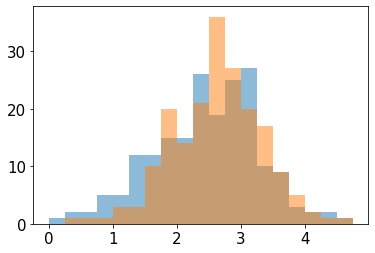

In [65]:
plt.hist(np.log10([d['start_pos']-d['opt_start_pos'] for d in deletions]), alpha=0.5, bins=np.arange(0, 5, 0.25))
plt.hist(np.log10([d['opt_end_pos']-d['end_pos'] for d in deletions]), alpha=0.5, bins=np.arange(0, 5, 0.25))
plt.show()

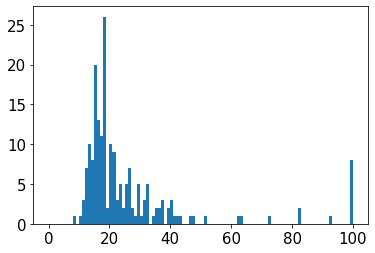

In [7]:
plt.hist(np.clip([d['quality_score'] for d in deletions if d['quality_score'] is not None], None, 100), 
         bins=np.arange(101))
plt.show()

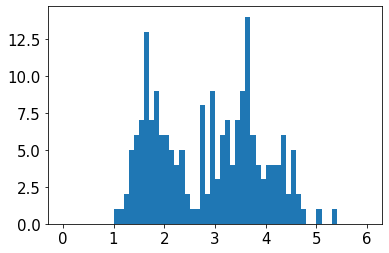

In [8]:
plt.hist(np.clip(np.log10([d['length'] for d in deletions]), 0, 6), 
         bins=np.arange(0, 6.1, 0.1))
plt.show()

# pull ground truth deletions

In [12]:
# pull deletions

bad_gts = set([('0/1', '0/0', '0/0'),
               ('1/1', '0/0', '0/0')])

ground_truth = []
with gzip.open('../data/hg002/HG002_SVs_Tier1_v0.6.vcf.gz', 'rt') as f:
    line = next(f)
    while line.startswith('#'):
        #print(line)
        line = next(f)
        
    for line in f:
        if 'SVTYPE=DEL' in line:
            # is deletion
            pieces = line.strip().split('\t')
            if pieces[0] in chroms:
                gt = pieces[9][:3]
                
                if (gt == '0/1' or gt == '1/1'):# and (pieces[6]=='.' or pieces[6]=='PASS'):
                    info = pieces[7].split(';')
                    dad = [x[9:] for x in info if x.startswith('HG003_GT=')][0]
                    mom = [x[9:] for x in info if x.startswith('HG004_GT=')][0]
                    if 'MendelianError=TRUE' not in info:
                        start_pos = int(pieces[1])
                        end_pos = [int(x[4:]) for x in info if x.startswith('END=')][0]

                        ground_truth.append({
                                                                'family': 'hg002',
                                                                'child': 'hg002',
                                                                'chrom': pieces[0],
                                                                'start_pos': start_pos,
                                                                'end_pos': end_pos,
                                                                'length': end_pos-start_pos,
                                                                'opt_start_pos': start_pos,
                                                                'opt_end_pos': end_pos,
                                                                'mom_gt': mom,
                                                                'dad_gt': dad,
                                                                'child_gt': gt,
                                                                'mother': 'hg004',
                                                                'father': 'hg003',
                                                                'is_inherited': True,
                                                                'is_denovo': False,
                                                                'quality_score': None,
                                                                'line': line
                                                    })

print(len(ground_truth))


22085


In [13]:
# check overlap

chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(deletions):
    chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))
gt_chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(ground_truth):
    gt_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))

del_to_overlaps = defaultdict(list)
gt_del_to_overlaps = defaultdict(list)

all_deletions = []
is_used = np.zeros((len(deletions),), dtype=bool)
gt_is_used = np.zeros((len(ground_truth),), dtype=bool)

for (fam, chrom), ds in chrom_fam_to_dels.items():
    sds = gt_chrom_fam_to_dels[(fam, chrom)]

    for i, d in ds:
        d_start, d_end = d['start_pos'], d['end_pos']
        for j, sb in sds:
            if (d['chrom']==sb['chrom']) and (d['child']==sb['child']):
                overlap = max(0, min(d_end, sb['end_pos']) - max(d_start, sb['start_pos']))
                wide_overlap = min(d['opt_end_pos'], sb['end_pos']) - max(d['opt_start_pos'], sb['start_pos'])
                
                if (overlap/d['length']>0.5) and (wide_overlap/sb['length']>0.5):
                    all_deletions.append((d, sb))
                    is_used[i] = True
                    gt_is_used[j] = True
for i in np.where(~is_used)[0]:
    all_deletions.append((deletions[i], None))
for j in np.where(~gt_is_used)[0]:
    all_deletions.append((None, ground_truth[j]))


print(len([d for d in all_deletions if d[0] is not None and d[1] is not None]),
     len([d for d in all_deletions if d[0] is not None and d[1] is None]),
     len([d for d in all_deletions if d[0] is None and d[1] is not None]))

69 125 22016


In [14]:
chrom_to_ok_region_starts = defaultdict(list)
chrom_to_ok_region_ends = defaultdict(list)

with open('../data/hg002/HG002_SVs_Tier1_v0.6.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chrom_to_ok_region_starts[pieces[0]].append(int(pieces[1])+1)
        chrom_to_ok_region_ends[pieces[0]].append(int(pieces[2]))

for chrom in chrom_to_ok_region_starts.keys():
    chrom_to_ok_region_starts[chrom] = np.array(chrom_to_ok_region_starts[chrom])
    chrom_to_ok_region_ends[chrom] = np.array(chrom_to_ok_region_ends[chrom])
        
is_ok = np.ones((len(all_deletions),), dtype=bool)
for i, (d, gt) in enumerate(all_deletions):  
    starts = chrom_to_ok_region_starts[gt['chrom'] if gt is not None else d['chrom']]
    ends = chrom_to_ok_region_ends[gt['chrom'] if gt is not None else d['chrom']]
    
    if gt is not None:
        start_ok = np.any((starts <= gt['start_pos']) & (gt['start_pos'] <= ends))
        end_ok = np.any((starts <= gt['end_pos']) & (gt['end_pos'] <= ends))
    else:
    
        start_overlaps = np.clip(np.minimum(d['start_pos'], ends) - np.maximum(d['opt_start_pos'], starts), 0, None)
        start_ok = np.sum(start_overlaps) > 0
    
        end_overlaps = np.clip(np.minimum(d['opt_end_pos'], ends) - np.maximum(d['end_pos'], starts), 0, None)
        end_ok = np.sum(end_overlaps) > 0

    is_ok[i] = start_ok and end_ok
print(np.sum(is_ok)/len(is_ok))
  
all_deletions = [x for x, ok in zip(all_deletions, is_ok) if ok]
print(len(all_deletions))


0.18770823953174245
4169


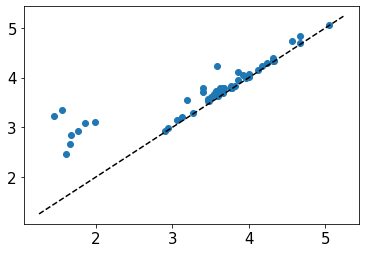

In [15]:
plt.scatter(np.log10([d[0]['length'] for d in all_deletions if d[0] is not None and d[1] is not None]),
           np.log10([d[1]['length'] for d in all_deletions if d[0] is not None and d[1] is not None]))
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

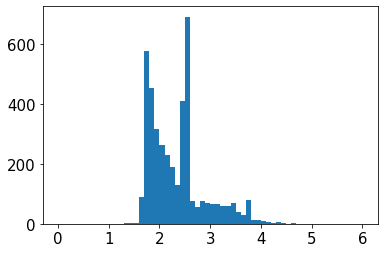

In [16]:
#print(lengths)
lengths = np.array([d[1]['length'] if (d[1] is not None) else d[0]['length'] for d in all_deletions])
plt.hist(np.log10(lengths), bins=np.arange(0, 6.1, 0.1))
plt.show()

In [17]:
all_deletions = [x for x, l in zip(all_deletions, lengths) if l>1000]
lengths = np.array([d[1]['length'] if (d[1] is not None) else d[0]['length'] for d in all_deletions])


In [18]:
print(np.sum([d['is_mat'] and (gt['mom_gt']=='0/1' or gt['mom_gt']=='1/1') for d, gt in all_deletions if d is not None and gt is not None])/np.sum([d['is_mat'] for d, gt in all_deletions if d is not None and gt is not None]),
     np.sum([d['is_mat'] and (gt['mom_gt']=='0/1' or gt['mom_gt']=='1/1') for d, gt in all_deletions if d is not None and gt is not None])/np.sum([(gt['mom_gt']=='0/1' or gt['mom_gt']=='1/1') for d, gt in all_deletions if d is not None and gt is not None]))
print(np.sum([d['is_pat'] and (gt['dad_gt']=='0/1' or gt['dad_gt']=='1/1') for d, gt in all_deletions if d is not None and gt is not None])/np.sum([d['is_mat'] for d, gt in all_deletions if d is not None and gt is not None]),
     np.sum([d['is_pat'] and (gt['dad_gt']=='0/1' or gt['dad_gt']=='1/1') for d, gt in all_deletions if d is not None and gt is not None])/np.sum([(gt['dad_gt']=='0/1' or gt['dad_gt']=='1/1') for d, gt in all_deletions if d is not None and gt is not None]))




0.9565217391304348 0.88
0.8695652173913043 0.8


In [19]:
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
chrom_to_region_types = defaultdict(list)
with open('../data/filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            if pieces[3]=='centromere':
                chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1)
                chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
                chrom_to_region_types[pieces[0][3:]].append(pieces[3])
            
#with open('../data/microsat.txt', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[1][3:] in chroms:
#            chrom_to_interval_starts[pieces[1][3:]].append(int(pieces[2]))
#            chrom_to_interval_ends[pieces[1][3:]].append(int(pieces[3]))
#            chrom_to_region_types[pieces[1][3:]].append('STR')
#            
#with open('../../FamilySeqError/data/btu356-suppl_data/btu356_LCR-hs37d5.bed/btu356_LCR-hs37d5.bed', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[0] in chroms:
#            chrom_to_interval_starts[pieces[0]].append(int(pieces[1])+1)
#            chrom_to_interval_ends[pieces[0]].append(int(pieces[2]))
#            chrom_to_region_types[pieces[0]].append('LCR')

region_type_mapping = {
    'SINE': 'SINE',
    'LINE': 'LINE',
    'DNA': 'DNA',
    'LTR': 'LTR',
    'Low_complexity': 'Low_complexity',
    'Simple_repeat': 'STR',
    'Satellite': 'Other',
     'Unknown': 'Other',
    'snRNA': 'Other',
    'tRNA': 'Other',
    'DNA?': 'Other',
    'srpRNA': 'Other',
    'rRNA': 'Other',
    'RC': 'Other',
    'Other': 'Other',
    'SINE?': 'Other',
    'scRNA': 'Other',
    'RNA': 'Other',
    'LTR?': 'Other',
    'Unknown?': 'Other',
    'LINE?': 'Other',
   
}

with open('../data/hg19.fa.out', 'r') as f:
    next(f) # skip header
    next(f) # skip header
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[4][3:]
        start_pos = int(pieces[5])
        end_pos = int(pieces[6])
        region_type = pieces[10].split('/')[0]
        
        chrom_to_interval_starts[chrom].append(start_pos)
        chrom_to_interval_ends[chrom].append(end_pos)
        chrom_to_region_types[chrom].append(region_type_mapping[region_type])
        



In [20]:
with open('../data/hg19.trf.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[0][3:]
        start_pos = int(pieces[1])
        end_pos = int(pieces[2])
        
        chrom_to_interval_starts[chrom].append(start_pos)
        chrom_to_interval_ends[chrom].append(end_pos)
        chrom_to_region_types[chrom].append('TRF')
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
    print(Counter(chrom_to_region_types[chrom]))

Counter({'SINE': 161838, 'LINE': 122076, 'LTR': 52338, 'DNA': 35183, 'TRF': 32524, 'STR': 31509, 'Low_complexity': 27226, 'Other': 2684, 'centromere': 2})
Counter({'SINE': 129092, 'LINE': 120533, 'LTR': 57510, 'DNA': 39451, 'STR': 33890, 'TRF': 32393, 'Low_complexity': 31272, 'Other': 2605, 'centromere': 2})
Counter({'SINE': 109734, 'LINE': 101012, 'LTR': 48146, 'DNA': 34468, 'STR': 26439, 'Low_complexity': 26171, 'TRF': 25701, 'Other': 2064, 'centromere': 2})
Counter({'LINE': 93200, 'SINE': 88355, 'LTR': 53033, 'Low_complexity': 30911, 'DNA': 27475, 'STR': 26681, 'TRF': 24409, 'Other': 2041, 'centromere': 2})
Counter({'SINE': 92725, 'LINE': 89512, 'LTR': 45760, 'DNA': 28972, 'STR': 24668, 'Low_complexity': 24458, 'TRF': 23532, 'Other': 1779, 'centromere': 2})
Counter({'SINE': 87640, 'LINE': 83593, 'LTR': 40212, 'DNA': 26962, 'Low_complexity': 23345, 'STR': 22989, 'TRF': 22591, 'Other': 1878, 'centromere': 2})
Counter({'SINE': 96072, 'LINE': 78347, 'LTR': 37055, 'DNA': 23973, 'TRF': 23

In [21]:
is_cen = np.zeros((len(all_deletions),), dtype=bool)

for chrom in chroms:
    print(chrom, end=' ')
    starts, ends = chrom_to_interval_starts[chrom], chrom_to_interval_ends[chrom]
    region_types = chrom_to_region_types[chrom]
       
    for rt, data in [('centromere', is_cen), 
                            ]:
        print(rt, end=' ')
        is_rt = np.array([r==rt for r in region_types])
            
        for i, (d, gt) in [x for x in enumerate(all_deletions)]:
            ch = gt['chrom'] if gt is not None else d['chrom']
            if chrom == ch:
                start_pos = gt['start_pos'] if gt is not None else (d['opt_start_pos']+d['start_pos'])/2
                end_pos = gt['end_pos'] if gt is not None else (d['opt_end_pos']+d['end_pos'])/2

                overlaps = np.clip(np.minimum(end_pos, ends[is_rt]) - np.maximum(start_pos, starts[is_rt]), 0, None)
                if np.sum(overlaps)/(end_pos-start_pos) > 0.66:
                    data[i] = True

    print()
print('centromere', np.sum(is_cen))
    

1 centromere 
2 centromere 
3 centromere 
4 centromere 
5 centromere 
6 centromere 
7 centromere 
8 centromere 
9 centromere 
10 centromere 
11 centromere 
12 centromere 
13 centromere 
14 centromere 
15 centromere 
16 centromere 
17 centromere 
18 centromere 
19 centromere 
20 centromere 
21 centromere 
22 centromere 
centromere 4


In [23]:
is_sine_break = np.zeros((len(all_deletions), ), dtype=bool)
is_line_break = np.zeros((len(all_deletions),), dtype=bool)
is_dna_break = np.zeros((len(all_deletions),), dtype=bool)
is_ltr_break = np.zeros((len(all_deletions),), dtype=bool)
is_str_break = np.zeros((len(all_deletions),), dtype=bool)
is_lc_break = np.zeros((len(all_deletions),), dtype=bool)
is_other_break = np.zeros((len(all_deletions),), dtype=bool)
is_trf_break = np.zeros((len(all_deletions),), dtype=bool)

is_sine_interval = np.zeros((len(all_deletions),), dtype=bool)
is_line_interval = np.zeros((len(all_deletions),), dtype=bool)
is_dna_interval = np.zeros((len(all_deletions),), dtype=bool)
is_ltr_interval = np.zeros((len(all_deletions),), dtype=bool)
is_str_interval = np.zeros((len(all_deletions),), dtype=bool)
is_lc_interval = np.zeros((len(all_deletions),), dtype=bool)
is_other_interval = np.zeros((len(all_deletions),), dtype=bool)
is_trf_interval = np.zeros((len(all_deletions),), dtype=bool)

for chrom in chroms:
    print(chrom, end=' ')
    starts, ends = chrom_to_interval_starts[chrom], chrom_to_interval_ends[chrom]
    region_types = chrom_to_region_types[chrom]
       
    for rt, data, data_int in [('SINE', is_sine_break, is_sine_interval), 
                     ('LINE', is_line_break, is_line_interval), 
                     ('DNA', is_dna_break, is_dna_interval), 
                     ('LTR', is_ltr_break, is_ltr_interval), 
                     ('STR', is_str_break, is_str_interval),
                     ('Low_complexity', is_lc_break, is_lc_interval),
                     ('Other', is_other_break, is_other_interval),
                     ('TRF', is_trf_break, is_trf_interval)
                            ]:
        print(rt, end=' ')
        is_rt = np.array([r==rt for r in region_types])
            
        for i, (d, gt) in [x for x in enumerate(all_deletions)]:
            ch = gt['chrom'] if gt is not None else d['chrom']
            if chrom == ch:
                if gt is not None:
                    start_pos, end_pos = gt['start_pos'], gt['end_pos']
                    if np.any((starts[is_rt] <= start_pos) & (start_pos <= ends[is_rt])):
                        data[i] = True
                    if np.any((starts[is_rt] <= end_pos) & (end_pos <= ends[is_rt])):
                        data[i] = True
                if d is not None:
                    start_overlaps = np.clip(np.minimum(d['start_pos'], ends[is_rt]) - np.maximum(d['opt_start_pos'], starts[is_rt]), 0, None)
                    if np.sum(start_overlaps) > 0:
                        data_int[i] = True

                    end_overlaps = np.clip(np.minimum(d['opt_end_pos'], ends[is_rt]) - np.maximum(d['end_pos'], starts[is_rt]), 0, None)
                    if np.sum(end_overlaps) > 0:
                        data_int[i] = True
                
                

    print()
    
is_str_break = is_str_break | (is_trf_break & ~is_sine_break & ~is_line_break & ~is_dna_break & ~is_ltr_break & ~is_lc_break & ~is_other_break)
is_str_interval = is_str_interval | (is_trf_interval & ~is_sine_interval & ~is_line_interval & ~is_dna_interval & ~is_ltr_interval & ~is_lc_interval & ~is_other_interval)
is_no_repeat_break = ~is_sine_break & ~is_line_break & ~is_dna_break & ~is_ltr_break & ~is_str_break & ~is_lc_break & ~is_other_break 
is_no_repeat_interval = ~is_sine_interval & ~is_line_interval & ~is_dna_interval & ~is_ltr_interval & ~is_str_interval & ~is_lc_interval & ~is_other_interval
print('SINE', np.sum(is_sine_break), np.sum(is_sine_interval))
print('LINE', np.sum(is_line_break), np.sum(is_line_interval))
print('DNA', np.sum(is_dna_break), np.sum(is_dna_interval))
print('LTR', np.sum(is_ltr_break), np.sum(is_ltr_interval))
print('STR', np.sum(is_str_break), np.sum(is_str_interval))
print('Low_complexity', np.sum(is_lc_break), np.sum(is_lc_interval))
print('Other', np.sum(is_other_break), np.sum(is_other_interval))
print('No_repeat', np.sum(is_no_repeat_break), np.sum(is_no_repeat_interval))



1 SINE LINE DNA LTR STR Low_complexity Other TRF 
2 SINE LINE DNA LTR STR Low_complexity Other TRF 
3 SINE LINE DNA LTR STR Low_complexity Other TRF 
4 SINE LINE DNA LTR STR Low_complexity Other TRF 
5 SINE LINE DNA LTR STR Low_complexity Other TRF 
6 SINE LINE DNA LTR STR Low_complexity Other TRF 
7 SINE LINE DNA LTR STR Low_complexity Other TRF 
8 SINE LINE DNA LTR STR Low_complexity Other TRF 
9 SINE LINE DNA LTR STR Low_complexity Other TRF 
10 SINE LINE DNA LTR STR Low_complexity Other TRF 
11 SINE LINE DNA LTR STR Low_complexity Other TRF 
12 SINE LINE DNA LTR STR Low_complexity Other TRF 
13 SINE LINE DNA LTR STR Low_complexity Other TRF 
14 SINE LINE DNA LTR STR Low_complexity Other TRF 
15 SINE LINE DNA LTR STR Low_complexity Other TRF 
16 SINE LINE DNA LTR STR Low_complexity Other TRF 
17 SINE LINE DNA LTR STR Low_complexity Other TRF 
18 SINE LINE DNA LTR STR Low_complexity Other TRF 
19 SINE LINE DNA LTR STR Low_complexity Other TRF 
20 SINE LINE DNA LTR STR Low_complexity 

In [24]:
is_val = [x[0] is not None and x[1] is not None for x in all_deletions]


# compare

In [25]:
quality_score = np.array([0 if d[0] is None else d[0]['quality_score'] for d in all_deletions])
ytrue = np.array([x[1] is not None for x in all_deletions])

In [26]:
overall_recall = np.sum(ytrue & (quality_score>0))/np.sum(ytrue)
overall_precision = np.sum(ytrue & (quality_score>0))/np.sum(quality_score>0)

print(overall_precision, overall_recall)

0.8958333333333334 0.08159392789373814


In [27]:
def get_confint(x, n):
    val = x/n
    lb, ub = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    return val, ub, lb

# Repeats at breakpoints / SNVs near breakpoints

In [60]:
breakpoint_variants_break = np.zeros((len(all_deletions),), dtype=int)
breakpoint_variants_int = np.zeros((len(all_deletions),), dtype=int)
for chrom in chroms:
    
    chrom_dels = [(i, x) for i, x in enumerate(all_deletions) if (x[0] is not None and x[0]['chrom']==chrom) or (x[1] is not None and x[1]['chrom']==chrom)]
    print(chrom, len(chrom_dels))
    
    coords = np.load('../../DATA/hg002/genotypes/chr.%s.0.gen.coordinates.npy' % chrom)
    pos = coords[:, 1]
    is_snp = coords[:, 2]==1
    is_pass = coords[:, 3]==1
    
    for i, (d, gt) in chrom_dels:
        if gt is not None:
            start_pos, end_pos = gt['start_pos'], gt['end_pos']
            breakpoint_variants_break[i] = np.sum(is_pass[(start_pos-50 <= pos) & (pos <= start_pos+50)]) + \
                                           np.sum(is_pass[(end_pos-50 <= pos) & (pos <= end_pos+50)])
            
        if d is not None:
            breakpoint_variants_int[i] = np.median([np.sum(is_pass[(start_pos-50 <= pos) & (pos <= start_pos+50)]) for start_pos in range(d['opt_start_pos'], d['start_pos'])]) + \
                                         np.median([np.sum(is_pass[(end_pos-50 <= pos) & (pos <= end_pos+50)]) for end_pos in range(d['end_pos'], d['opt_end_pos'])])

            #breakpoint_variants_int[i] = 100*np.sum(is_pass[(d['opt_start_pos']-50 <= pos) & (pos <= d['start_pos']+50)])/(d['start_pos']-d['opt_start_pos']) + \
            #                             100*np.sum(is_pass[(d['end_pos']-50 <= pos) & (pos <= d['opt_end_pos']+50)])/(d['opt_end_pos']-d['end_pos'])
            #start_pos, end_pos = (d['start_pos']+d['opt_start_pos'])/2, (d['end_pos']+d['opt_end_pos'])/2
            #breakpoint_variants_int[i] = np.sum(is_pass[(start_pos-50 <= pos) & (pos <= start_pos+50)]) + \
            #                               np.sum(is_pass[(end_pos-50 <= pos) & (pos <= end_pos+50)])
            
        
    
    print(coords.shape)

1 43
(512689, 4)
2 45
(512066, 4)
3 38
(432550, 4)
4 53
(456939, 4)
5 34
(395902, 4)
6 36
(404521, 4)
7 27
(370245, 4)
8 25
(342624, 4)
9 23
(293137, 4)
10 23
(321959, 4)
11 27
(314117, 4)
12 27
(300916, 4)
13 18
(232670, 4)
14 15
(212842, 4)
15 12
(198020, 4)
16 8
(200132, 4)
17 14
(180078, 4)
18 12
(178471, 4)
19 23
(150813, 4)
20 12
(134870, 4)
21 7
(107299, 4)
22 10
(67168, 4)


[26.  9.  8.] [27.  9. 12.]


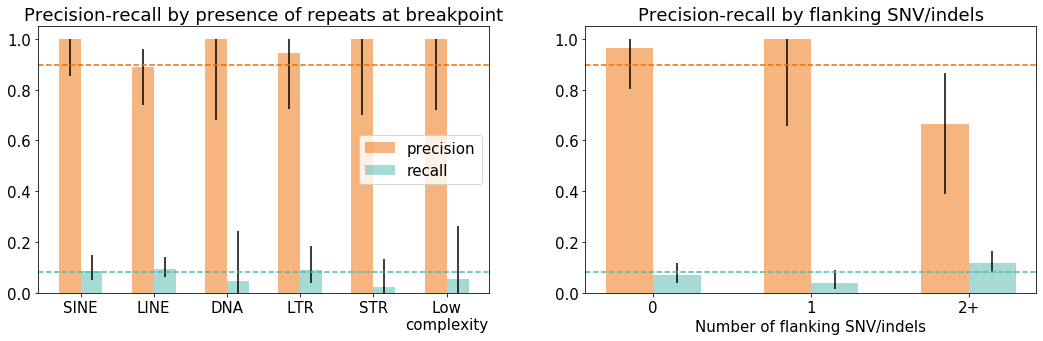

In [62]:
fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
precision_x, precision_n, recall_x, recall_n = np.zeros((6,)), np.zeros((6,)), np.zeros((6,)), np.zeros((6,))

for i, (f_break, f_int) in enumerate([
                       (is_sine_break, is_sine_interval), 
                       (is_line_break, is_line_interval), 
                       (is_dna_break, is_dna_interval), 
                       (is_ltr_break, is_ltr_interval), 
                       (is_str_break, is_str_interval), 
                       (is_lc_break, is_lc_interval)]):
    #print(np.sum(f), np.sum(quality_score[f]>0),
    #      np.sum(ytrue[f] & (quality_score[f]>0))/np.sum(ytrue[f]), 
    #      np.sum(ytrue[f] & (quality_score[f]>0))/np.sum(quality_score[f]>0))
    precision_x[i] = np.sum(ytrue[f_int] & (quality_score[f_int]>0))
    precision_n[i] = np.sum(quality_score[f_int]>0)
    recall_x[i] = np.sum(ytrue[f_break] & (quality_score[f_break]>0))
    recall_n[i] = np.sum(ytrue[f_break])
    
precision, precision_ub, precision_lb = get_confint(precision_x, precision_n)
recall, recall_ub, recall_lb = get_confint(recall_x, recall_n)


plt.bar(np.arange(6)-0.15, precision, yerr=(precision-precision_lb, precision_ub-precision), 
        width=0.3, alpha=0.5, label='precision', color=colors[0])
plt.bar(np.arange(6)+0.15, recall, yerr=(recall-recall_lb, recall_ub-recall), 
        width=0.3, alpha=0.5, label='recall', color=colors[1])   
plt.axhline(overall_precision, linestyle='--', color=colors[0])
plt.axhline(overall_recall, linestyle='--', color=colors[1])

plt.xticks(np.arange(6), ['SINE', 'LINE', 'DNA', 'LTR', 'STR', 'Low\ncomplexity'])
plt.title('Precision-recall by presence of repeats at breakpoint')
#plt.xlabel('Repeat Type')
plt.legend()
#plt.ylim(-0.1, 1.1)

plt.subplot(1, 2, 2, sharey=ax)

precision_x, precision_n, recall_x, recall_n = np.zeros((3,)), np.zeros((3,)), np.zeros((3,)), np.zeros((3,))

for i in range(3):
    precision_x[i] = np.sum(ytrue[np.clip(breakpoint_variants_int, 0, 2)==i] & (quality_score[np.clip(breakpoint_variants_int, 0, 2)==i]>0))
    precision_n[i] = np.sum(quality_score[np.clip(breakpoint_variants_int, 0, 2)==i]>0)
    recall_x[i] = np.sum(ytrue[np.clip(breakpoint_variants_break, 0, 2)==i] & (quality_score[np.clip(breakpoint_variants_break, 0, 2)==i]>0))
    recall_n[i] = np.sum(ytrue[np.clip(breakpoint_variants_break, 0, 2)==i])
    #print(i, np.sum(f), np.sum(quality_score[f]>0),
    #          x[i]/precision_n[i], x[i]/recall_n[i]
    #          )
    
print(precision_x, precision_n)
precision, precision_ub, precision_lb = get_confint(precision_x, precision_n)
recall, recall_ub, recall_lb = get_confint(recall_x, recall_n)

plt.bar(np.arange(3)-0.15, precision, yerr=(precision-precision_lb, precision_ub-precision), 
        width=0.3, alpha=0.5, label='precision', color=colors[0])
plt.bar(np.arange(3)+0.15, recall, yerr=(recall-recall_lb, recall_ub-recall), 
        width=0.3, alpha=0.5, label='recall', color=colors[1])

plt.axhline(overall_precision, linestyle='--', color=colors[0])
plt.axhline(overall_recall, linestyle='--', color=colors[1])

#plt.plot(np.arange(6), precision, label='precision')
#plt.fill_between(np.arange(6), precision_lb, precision_ub, alpha=0.1)
#plt.plot(np.arange(6), recall, label='recall')
#plt.fill_between(np.arange(6), recall_lb, recall_ub, alpha=0.1)

plt.xticks(np.arange(3), ['0', '1', '2+'])
plt.title('Precision-recall by flanking SNV/indels')
#plt.legend()
plt.xlabel('Number of flanking SNV/indels')
#plt.ylim(None, 1.1)

#plt.show()
plt.tight_layout()
fig.savefig('../plots/breakpoints.png', dpi=fig.dpi)

# Precision/Recall as a function of deletion length and SNVs within deletion

In [928]:
internal_variants = np.zeros((len(all_deletions),), dtype=int)
for chrom in chroms:
    
    chrom_dels = [(i, x) for i, x in enumerate(all_deletions) if (x[0] is not None and x[0]['chrom']==chrom) or (x[1] is not None and x[1]['chrom']==chrom)]
    print(chrom, len(chrom_dels))
    
    coords = np.load('../../DATA/hg002/genotypes/chr.%s.0.gen.coordinates.npy' % chrom)
    pos = coords[:, 1]
    is_snp = coords[:, 2]==1
    is_pass = coords[:, 3]==1
    
    
    #gen = sparse.load_npz('../../DATA/hg002/genotypes/chr.%s.0.gen.npz' % chrom).A
    #is_hom = np.all(gen==0, axis=0) | np.all(gen==2, axis=0)

    for i, (d, gt) in chrom_dels:
        start_pos = gt['start_pos'] if gt is not None else (d['opt_start_pos']+d['start_pos'])/2
        end_pos = gt['end_pos'] if gt is not None else (d['opt_end_pos']+d['end_pos'])/2
        
        internal_variants[i] = np.sum((is_snp & is_pass)[(start_pos <= pos) & (pos <= end_pos)])
    
    print(coords.shape, gen.shape)

1 43
(512689, 4) (3, 67168)
2 45
(512066, 4) (3, 67168)
3 38
(432550, 4) (3, 67168)
4 53
(456939, 4) (3, 67168)
5 34
(395902, 4) (3, 67168)
6 36
(404521, 4) (3, 67168)
7 27
(370245, 4) (3, 67168)
8 25
(342624, 4) (3, 67168)
9 23
(293137, 4) (3, 67168)
10 23
(321959, 4) (3, 67168)
11 27
(314117, 4) (3, 67168)
12 27
(300916, 4) (3, 67168)
13 18
(232670, 4) (3, 67168)
14 15
(212842, 4) (3, 67168)
15 12
(198020, 4) (3, 67168)
16 8
(200132, 4) (3, 67168)
17 14
(180078, 4) (3, 67168)
18 12
(178471, 4) (3, 67168)
19 23
(150813, 4) (3, 67168)
20 12
(134870, 4) (3, 67168)
21 7
(107299, 4) (3, 67168)
22 10
(67168, 4) (3, 67168)


[0.89583333 0.89583333 0.91489362 0.91304348 0.91111111 0.93181818
 0.93023256 0.92857143 0.95121951 0.95       0.94871795 0.97368421
 0.97297297 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
[0.08159393 0.08958333 0.09168443 0.09271523 0.0940367  0.09738717
 0.10126582 0.09898477 0.10427807 0.11111111 0.11783439 0.12171053
 0.15       0.18       0.18421053 0.18378378 0.18232044 0.18823529
 0.19496855 0.2027027  0.2        0.20289855 0.21774194 0.21138211
 0.36231884 0.35820896 0.34848485 0.34920635 0.33870968 0.33898305
 0.33333333 0.34615385 0.44736842 0.47058824 0.48387097 0.53846154
 0.52       0.52173913 0.64705882 0.625      0.6        0.57142857
 0.58333333 0.6        0.625  

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


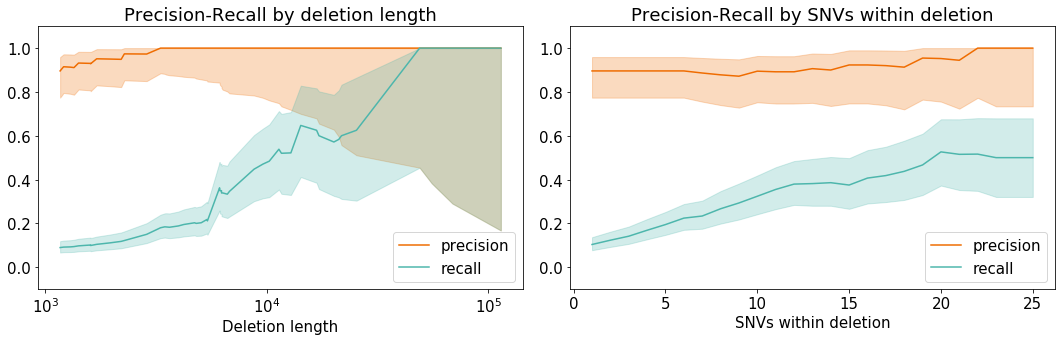

In [945]:
fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)

precision, recall, thresholds = precision_recall_curve(ytrue, lengths * (quality_score>0))
x, precision_n, recall_n = np.zeros((len(thresholds),)), np.zeros((len(thresholds),)), np.zeros((len(thresholds),))
for i, t in enumerate(thresholds):  
    x[i] = np.sum((quality_score[lengths>=t]>0) & ytrue[lengths>=t])
    recall_n[i] = np.sum(ytrue[lengths>=t])
    precision_n[i] = np.sum(quality_score[lengths>=t]>0)

precision, precision_ub, precision_lb = get_confint(x, precision_n)
recall, recall_ub, recall_lb = get_confint(x, recall_n)
print(precision)
print(recall)
print(thresholds[recall==1.0])

plt.plot(np.log10(thresholds), precision, label='precision', color=colors[0])
plt.fill_between(np.log10(thresholds), precision_ub, precision_lb, alpha=0.25, color=colors[0])
plt.plot(np.log10(thresholds), recall, label='recall', color=colors[1])
plt.fill_between(np.log10(thresholds), recall_ub, recall_lb, alpha=0.25, color=colors[1])
plt.xticks(np.arange(3, 6), ['$10^{%d}$' % i for i in np.arange(3, 6)])
plt.xlabel('Deletion length')
plt.legend()
plt.title('Precision-Recall by deletion length')

plt.subplot(1, 2, 2, sharey=ax)

x, precision_n, recall_n = np.zeros((26,)), np.zeros((26,)), np.zeros((26,))
for i in range(26):  
    x[i] = np.sum((quality_score[internal_variants>=i]>0) & ytrue[internal_variants>=i])
    recall_n[i] = np.sum(ytrue[internal_variants>=i])
    precision_n[i] = np.sum(quality_score[internal_variants>=i]>0)

precision, precision_ub, precision_lb = get_confint(x, precision_n)
recall, recall_ub, recall_lb = get_confint(x, recall_n)
print(precision)
print(recall)
print(np.arange(26)[recall>=0.5])

plt.plot(np.arange(1, 26), precision[1:], label='precision', color=colors[0])
plt.fill_between(np.arange(1, 26), precision_ub[1:], precision_lb[1:], alpha=0.25, color=colors[0])
plt.plot(np.arange(1, 26), recall[1:], label='recall', color=colors[1])
plt.fill_between(np.arange(1, 26), recall_ub[1:], recall_lb[1:], alpha=0.25, color=colors[1])
#plt.xticks(np.arange(25))
plt.xlabel('SNVs within deletion')
plt.legend()
plt.ylim([-0.1, 1.1])
plt.title('Precision-Recall by SNVs within deletion')

plt.tight_layout()
#plt.show()
fig.savefig('../plots/dellength_snvs.png', dpi=fig.dpi)


# Take a look at a region up close

In [680]:
#chrom, start_pos, end_pos = '14', 106270403, 106322561
chrom, start_pos, end_pos = '19', 35662174-10000, 35665664+10000

gt_detail = -np.ones((end_pos-start_pos, 3), dtype=int)
del_detail = -np.ones((end_pos-start_pos, 3), dtype=int)

gtcode = {'./.': 3, '0/0': 0, '0/1': 1, '1/1': 2, './1': 1}

with gzip.open('../data/hg002/HG002_SVs_Tier1_v0.6.vcf.gz', 'rt') as f:
    line = next(f)
    while line.startswith('#'):
        print(line)
        line = next(f)
        
    for line in f:
        if 'SVTYPE=DEL' in line:
            # is deletion
            pieces = line.strip().split('\t')
            if pieces[0]==chrom and pieces[6]=='PASS':
                s = int(pieces[1])
                e = [int(x[4:]) for x in info if x.startswith('END=')][0]
                
                gt = pieces[9][:3]
                if (min(end_pos, e)-max(start_pos, s)>0) and (gt=='0/1' or gt=='1/1'):
                    print(line)
                    dad = [x[9:] for x in info if x.startswith('HG003_GT=')][0]
                    mom = [x[9:] for x in info if x.startswith('HG004_GT=')][0]
                    
                    gt_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 0] = gtcode[gt]
                    gt_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 1] = gtcode[mom]
                    gt_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 2] = gtcode[dad]
                    
with open('%s/deletions.json' % phase_dir) as f:
    for d in json.load(f):
        if d['is_inherited'] and d['chrom']==chrom and min(end_pos, d['end_pos'])-max(start_pos, d['start_pos'])>0:
            s, e = d['start_pos'], d['end_pos']
            gt = '0/1'
            mom = '0/1' if d['is_mat'] else '0/0'
            dad = '0/1' if d['is_pat'] else '0/0'
            del_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 0] = gtcode[gt]
            del_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 1] = gtcode[mom]
            del_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 2] = gtcode[dad]    


##fileformat=VCFv4.2

##fileDate=20180605

##reference=GRCh37

##contig=<ID=1,length=249250621>

##contig=<ID=2,length=243199373>

##contig=<ID=3,length=198022430>

##contig=<ID=4,length=191154276>

##contig=<ID=5,length=180915260>

##contig=<ID=6,length=171115067>

##contig=<ID=7,length=159138663>

##contig=<ID=8,length=146364022>

##contig=<ID=9,length=141213431>

##contig=<ID=10,length=135534747>

##contig=<ID=11,length=135006516>

##contig=<ID=12,length=133851895>

##contig=<ID=13,length=115169878>

##contig=<ID=14,length=107349540>

##contig=<ID=15,length=102531392>

##contig=<ID=16,length=90354753>

##contig=<ID=17,length=81195210>

##contig=<ID=18,length=78077248>

##contig=<ID=19,length=59128983>

##contig=<ID=20,length=63025520>

##contig=<ID=21,length=48129895>

##contig=<ID=22,length=51304566>

##contig=<ID=X,length=155270560>

##contig=<ID=Y,length=59373566>

##contig=<ID=MT,length=16569>

##FILTER=<ID=NoConsensusGT,Description="No individual had genotypes from svviz agree 

19	404476	HG2_PB_SVrefine2Falcon1plusDovetail_5428	TGGGGGGGGCACGGGGTCCTGCCCTGAGGGGTGTGGGGGGGACGGGGTCCTGCCCTGAGGGGTGTGGGGGGGACGGGGTCCTGCCCTGAGGGGTGTG	T	10	PASS	ClusterIDs=HG3_PB_pbsv_17416:HG2_PB_assemblyticsfalcon_12007:HG2_PB_SVrefine2PB10Xhap12_12890:HG2_PB_SVrefine2Falcon1plusDovetail_5428:HG4_PB_pbsv_17639:HG2_PB_pbsv_17724:HG2_PB_HySA_32215;NumClusterSVs=7;ExactMatchIDs=HG2_PB_SVrefine2Falcon1plusDovetail_5428:HG2_PB_SVrefine2PB10Xhap12_12890;NumExactMatchSVs=2;ClusterMaxShiftDist=0.0717948717948718;ClusterMaxSizeDiff=0.0717948717948718;ClusterMaxEditDist=0.145833333333333;PBcalls=7;Illcalls=0;TenXcalls=0;CGcalls=0;PBexactcalls=2;Illexactcalls=0;TenXexactcalls=0;CGexactcalls=0;HG2count=5;HG3count=1;HG4count=1;NumTechs=1;NumTechsExact=1;SVLEN=-96;DistBack=129;DistForward=-88;DistMin=-88;DistMinlt1000=TRUE;MultiTech=FALSE;MultiTechExact=FALSE;SVTYPE=DEL;END=404572;sizecat=50to99;DistPASSHG2gt49Minlt1000=FALSE;DistPASSMinlt1000=FALSE;MendelianError=FALSE;HG003_GT=./.;HG004_GT=./.;TRa

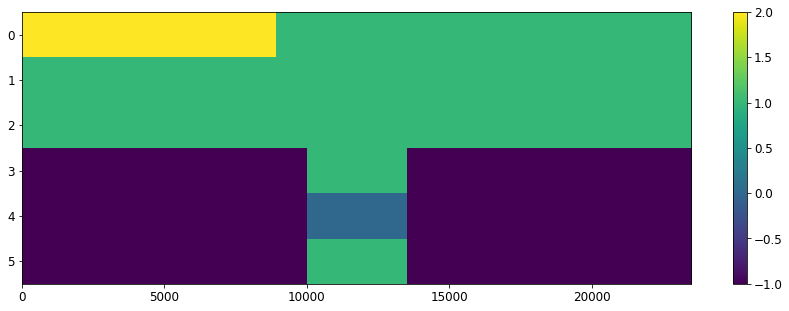

In [681]:
plt.figure(figsize=(15, 5))
plt.imshow(np.vstack((gt_detail.T, del_detail.T)), aspect='auto')
plt.colorbar()
plt.show()